#Source Injector

The source injector can produce mock simulated data independent of the MEGAlib software.

Standard data simulation requires the users to install and use MEGAlib to convolve the source model with the detector effects to generate data. The source injector utilizes the response generated by intensive simulation, which contains the statistical detector effects. With the source injector, you can convolve response, source model, and orientation to gain the mock data quickly. 

The advantages of using the source injector include:

- No need to install and use MEGAlib
- Get the data much faster than the standard simulation pipeline
- The generated data are in the format that can be used for spectral fitting, localization, imaging, etc.

The disadvantages are:

- The data are binned based on the binning of the response, which means that you lost the unbinned event distribution as you will get from the MEGAlib pipeline.
- If the response is coarse, the data you generated might not be precise.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord
from astromodels.functions.function import Function1D, FunctionMeta
from cosipy import SpacecraftFile, SourceInjector
from cosipy.threeml.custom_functions import SpecFromDat
%matplotlib inline

In [139]:
data_dir = Path("")  # Current directory by default. Modify if you want a different path

In [140]:
%%capture
zipped_response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip"
response_path = data_dir/"SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5"

# download response file ~839.62 MB
if not response_path.exists():
    
    fetch_wasabi_file("COSI-SMEX/DC2/Responses/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5.zip", zipped_response_path)

    # unzip the response file
    shutil.unpack_archive(zipped_response_path)
    
    # delete the zipped response to save space
    os.remove(zipped_response_path)

In [141]:
%%capture
orientation_path = data_dir/"off_axis_smaller_than_113.ori"

# download orientation file ~684.38 MB
if not orientation_path.exists():
    fetch_wasabi_file("COSI-SMEX/DC2/Data/Orientation/20280301_3_month.ori", orientation_path)

## Inject a blazar source response

### Method 1 : Define the spectrum model

In [142]:
"""index = -2.2
K = 1 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value= piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit"""

'index = -2.2\nK = 1 / u.cm / u.cm / u.s / u.keV\npiv = 100 * u.keV\nspectrum = Powerlaw()\nspectrum.index.value = index\nspectrum.K.value = K.value\nspectrum.piv.value= piv.value \nspectrum.K.unit = K.unit\nspectrum.piv.unit = piv.unit'

### Method 2: Read the spectrum from a file

In [143]:
# Load data from the text file, skipping the index column
data = np.loadtxt("Crab_spec.csv", delimiter="\t", skiprows=1, usecols=(1, 2))

# Extract energies and flux values
energies = data[:, 0]  # Second column contains energies values
fluxes = data[:, 1]  # Third column contains flux values


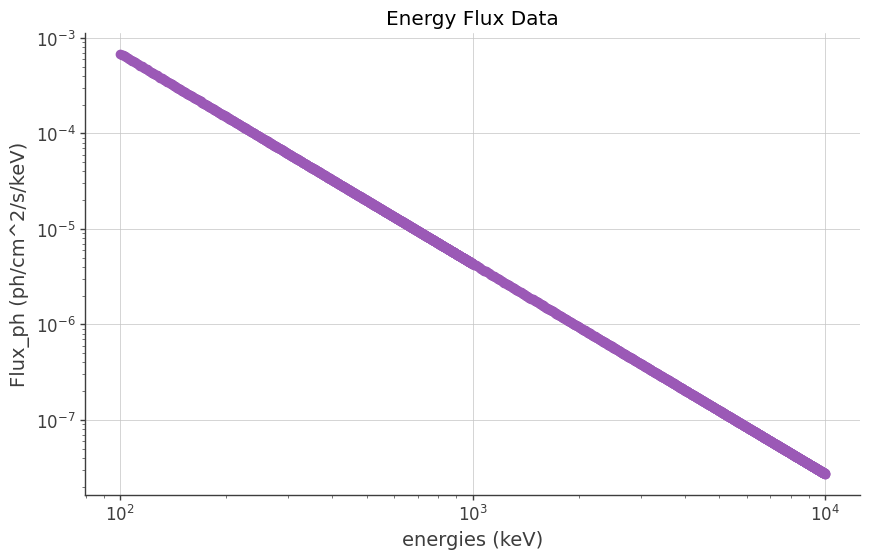

In [144]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(energies, fluxes, marker="o", linestyle="-")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("energies (keV)")
#plt.ylabel("Flux (keV cm^-2 s^-1)")
plt.ylabel("Flux_ph (ph/cm^2/s/keV)")
plt.title("Energy Flux Data")
plt.grid(True)
plt.show()

#### Interpolate the data to create a piecwise function

In [145]:
interpolation_function = interp1d(energies, fluxes, kind="linear")


def pf(x):
    if x < energies[0]:
        return interpolation_function(energies[0])
    elif x > energies[-1]:
        return interpolation_function(energies[-1])
    else:
        return interpolation_function(x)

#### Comparing the interpolated data to the example dataset

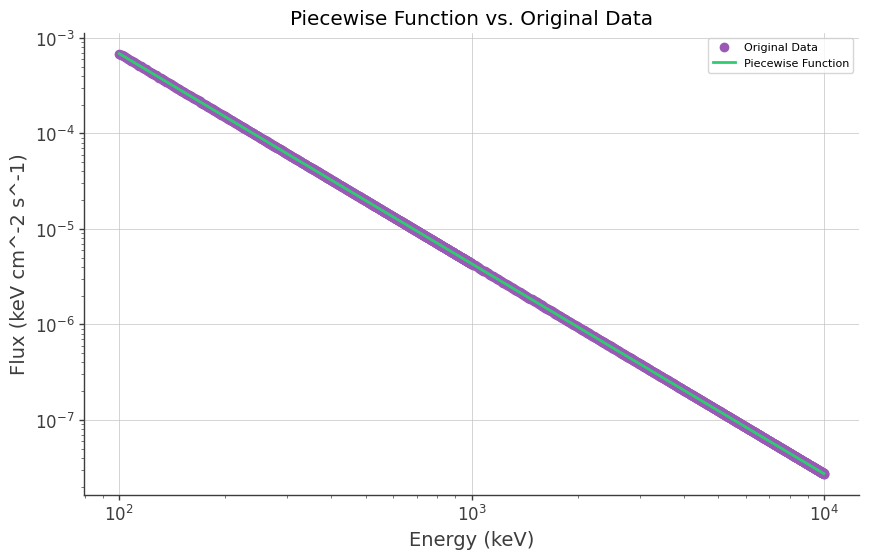

In [146]:
# Define energy values for plotting
x_values = np.linspace(min(energies), max(energies), 1000)

# Calculate flux values using the piecewise function
piecewise_flux = [pf(x) for x in x_values]
plt.figure(figsize=(10, 6))
# Plot the original data
plt.plot(energies, fluxes, "o", label="Original Data")

# Plot the piecewise function
plt.plot(x_values, piecewise_flux, label="Piecewise Function")
plt.xscale("log")
plt.yscale("log")

# Add labels and legend
plt.xlabel("Energy (keV)")
plt.ylabel("Flux (keV cm^-2 s^-1)")
plt.title("Piecewise Function vs. Original Data")
plt.legend()
plt.grid(True)
plt.show()

In [147]:
class SpecFromTxt(Function1D, metaclass=FunctionMeta):
    r"""
    description :
        A  spectrum loaded from a dat file
    parameters :
        K :
            desc : Normalization
            initial value : 1.0
            is_normalization : True
            transformation : log10
            min : 1e-30
            max : 1e3
            delta : 0.1
    properties:
        dat:
            desc: the data file to load
            initial value: test.dat
            defer: True
    """

    def _set_units(self, x_unit, y_unit):

        self.K.unit = y_unit

    def evaluate(self, x, K):
        dataFlux = np.genfromtxt(
            self.dat.value, comments="#", usecols=(2), skip_footer=1, skip_header=5
        )
        dataEn = np.genfromtxt(
            self.dat.value, comments="#", usecols=(1), skip_footer=1, skip_header=5
        )

        #dataFlux = dataFlux / sum(dataFlux)  # normalized since the dat file has one point per keV
        
        interpolation_function = interp1d(dataEn, dataFlux, kind="linear")

        def interp_flux(x):
            if x < dataEn[0]:
                return interpolation_function(dataEn[0])
            elif x > dataEn[-1]:
                return interpolation_function(dataEn[-1])
            else:
                return interpolation_function(x)

        if isinstance(x, u.Quantity):
            x = x.value

        result = np.array([K * interp_flux(xi) for xi in x])

        return result

In [148]:
spectrum = SpecFromTxt(K=1, dat="Crab_spec.csv")

### Read orientation file

In [149]:
# Read the 3-month orientation
# It is the pointing of the spacecraft during the the mock simlulation
ori = SpacecraftFile.parse_from_file(orientation_path)

### Get the expected counts and save to a data file

In [150]:
# Define an injector by the response
injector = SourceInjector(response_path=response_path)

In [151]:
# Define the coordinate of the point source
source_coord = SkyCoord(l=184.56, b=-5.78, frame="galactic", unit="deg")


WARNING IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



CPU times: user 16.8 s, sys: 1.16 s, total: 18 s
Wall time: 18.2 s


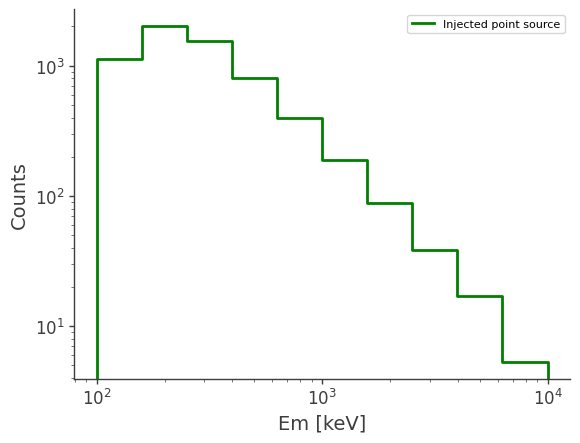

In [152]:
%%time

# Get the data of the injected source
injector.inject_point_source(spectrum=spectrum, coordinate=source_coord, orientation=ori, source_name="point_source",
                             make_spectrum_plot=True, data_save_path="crab_piecewise_injected.h5", project_axes=None)

Text(0.5, 1.0, 'Comparison b/w model and piecewise injected counts')

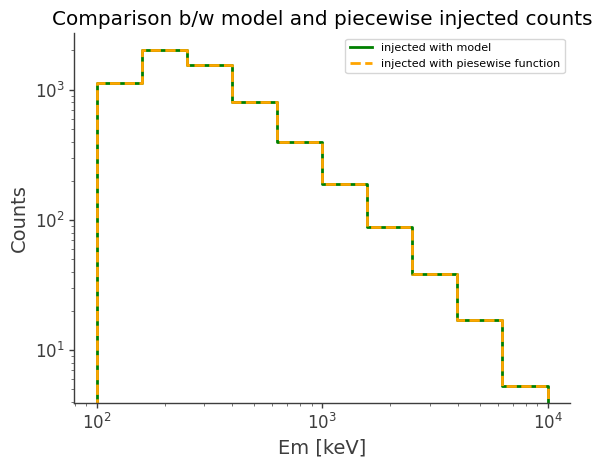

In [153]:
from histpy import Histogram

model_injected = Histogram.open("crab_dc2_injected.h5").project("Em")
piecewise_injected = Histogram.open("crab_piecewise_injected.h5").project("Em")

ax,plot = model_injected.draw(label = "injected with model", color = "green")

piecewise_injected.draw(ax, label = "injected with piesewise function", color = "orange", linestyle = "dashed")


ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Counts")
ax.set_title("Comparison b/w model and piecewise injected counts")